<img src="https://full-stack-assets.s3.eu-west-3.amazonaws.com/M08-deep-learning/AT%26T_logo_2016.svg" alt="AT&T LOGO" width="50%" />

# SPAM detector

## Company's Description 📇

AT&T Inc. is an American multinational telecommunications holding company headquartered at Whitacre Tower in Downtown Dallas, Texas. It is the world's largest telecommunications company by revenue and the third largest provider of mobile telephone services in the U.S. As of 2022, AT&T was ranked 13th on the Fortune 500 rankings of the largest United States corporations, with revenues of $168.8 billion! 😮

## Project 🚧

One of the main pain point that AT&T users are facing is constant exposure to SPAM messages.

AT&T has been able to manually flag spam messages for a time, but they are looking for an automated way of detecting spams to protect their users.

## Goals 🎯

Your goal is to build a spam detector, that can automatically flag spams as they come based solely on the sms' content.

## Scope of this project 🖼️

To start off, AT&T would like you to use the folowing dataset:

[Dowload the Dataset](https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+Learning/project/spam.csv)

## Helpers 🦮

To help you achieve this project, here are a few tips that should help you: 

### Start simple
A good deep learing model does not necessarily have to be super complicated!

### Transfer learning
You do not have access to a whole lot of data, perhaps channeling the power of a more sophisticated model trained on billions of observations might help!

## Deliverable 📬

To complete this project, your team should: 

* Write a notebook that runs preprocessing and trains one or more deep learning models in order to predict the spam or ham nature of the sms
* State the achieved performance clearly

# Data Preprocessing

### Libraries

In [1]:
import tensorflow as tf
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import warnings
warnings.filterwarnings('ignore')


### Import & clean the Dataset

In [2]:
# Import dataset

dataset = pd.read_csv("spam.csv", encoding="latin-1")
dataset.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
# Clean the dataset

# Keep only the useful columns
df = dataset[['v1', 'v2']].copy()

# Rename columns for clarity
df.columns = ['label', 'message']

# Check for missing values
print("Missing values:", df.isnull().sum().to_dict())

# Encode labels: ham = 0, spam = 1
df['label_num'] = df['label'].map({'ham': 0, 'spam': 1})

Missing values: {'label': 0, 'message': 0}


### Dataset overview

Total number of SMS: 5572

label
ham     4825
spam     747
Name: count, dtype: int64


<Axes: xlabel='label'>

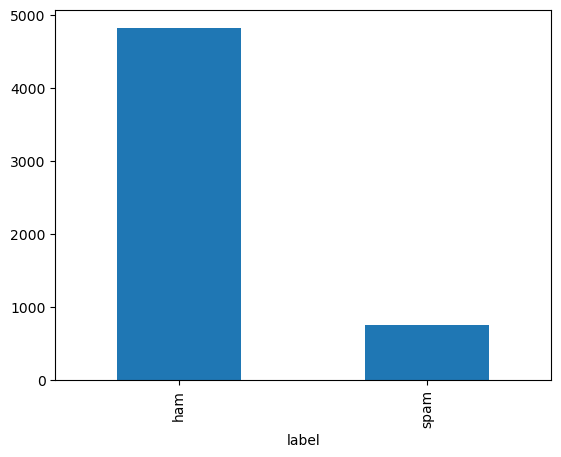

In [4]:
# Display a quick overview
print("Total number of SMS:", len(df))
print()
print(df['label'].value_counts())

df['label'].value_counts().plot.bar()

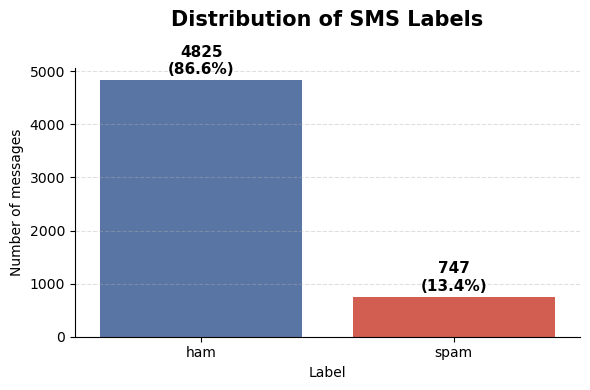

In [5]:
# Compute counts and percentages
counts = df['label'].value_counts()
percentages = counts / counts.sum() * 100

# Define consistent colors
colors = ['#4C72B0', '#E74C3C']  # same blue + vivid red

plt.figure(figsize=(6,4))
bars = sns.barplot(
    x=counts.index,
    y=counts.values,
    palette=colors
)

# Annotate counts and percentages above bars
for i, (count, pct) in enumerate(zip(counts, percentages)):
    bars.text(
        i, count + 60,               # raise labels higher above bars
        f'{count}\n({pct:.1f}%)',
        ha='center', va='bottom',
        fontsize=11, fontweight='bold', color='black'
    )

plt.title('Distribution of SMS Labels', fontsize=15, fontweight='bold', pad=30)  # pad raises title
plt.xlabel('Label')
plt.ylabel('Number of messages')
plt.grid(axis='y', linestyle='--', alpha=0.4)
sns.despine()
plt.tight_layout()
plt.show()


In [6]:
df.head()

,label,message,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


### Prepare the Dataset

In [7]:
# Clean and normalize text

def clean_text(text):
    text = text.lower()  # lowercase
    text = re.sub(r"http\S+", " ", text)  # remove URLs
    text = re.sub(r"[^a-z0-9\s\']", " ", text)  # keeps only the letters, the numbers, spaces and apostrophe
    text = re.sub(r"\s+", " ", text).strip()  # remove multiple spaces
    return text

df['clean_message'] = df['message'].apply(clean_text)

# Display before/after examples
for i in range(3):
    print(f"Before: {df['message'].iloc[i]}")
    print(f"After : {df['clean_message'].iloc[i]}")
    print("---")


Before: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
After : go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat
---
Before: Ok lar... Joking wif u oni...
After : ok lar joking wif u oni
---
Before: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
After : free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005 text fa to 87121 to receive entry question std txt rate t c's apply 08452810075over18's
---


In [8]:
# Split dataset into training and test sets
from sklearn.model_selection import train_test_split

X = df['clean_message']
y = df['label_num']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")
print("\nLabel distribution in training set:")
print(y_train.value_counts(normalize=True))


Training set: 4457 samples
Test set: 1115 samples

Label distribution in training set:
label_num
0    0.865829
1    0.134171
Name: proportion, dtype: float64


Choice of vocabulary size (max_tokens=10 000)
After cleaning the dataset, we found ~8 640 unique words.
To ensure full coverage of the vocabulary and handle potential unseen words, we kept a vocab_size of 10 000.
This value avoids out-of-vocabulary tokens while maintaining a manageable model size.

In [9]:
# Checking how many words to keep
import itertools
from collections import Counter

# Split and count words
words = list(itertools.chain.from_iterable(df['clean_message'].str.split()))
word_counts = Counter(words)

print("Unique words:", len(word_counts))
print(word_counts.most_common(20))


Unique words: 8812
[('i', 2369), ('to', 2242), ('you', 2152), ('a', 1435), ('the', 1328), ('u', 1173), ('and', 979), ('in', 898), ('is', 889), ('me', 802), ('my', 762), ('for', 705), ('your', 680), ('it', 646), ('of', 622), ('call', 591), ('have', 575), ('on', 537), ('2', 528), ('that', 524)]


output_sequence_length=40 — SMS messages are usually short.
By fixing each sequence to 40 tokens, we ensure that all messages have the same length.
Shorter messages are padded (filled with zeros) so that every sequence in a batch has equal shape,
and longer messages are truncated (cut after the 40th token).
This uniform shape is required for efficient batch processing and for the LSTM to handle inputs consistently.

vectorizer.adapt(X_train) — The vocabulary is built only on the training data, never on the test set.
This avoids data leakage, meaning the model will not “peek” at unseen data during training.
It guarantees that evaluation metrics reflect the model’s real ability to generalize to new, unseen messages.

vectorizer.get_vocabulary() returns the list of all tokens the layer has learned, ordered by frequency.
The first few entries are reserved tokens such as "[PAD]" (padding) and "[OOV]" (out-of-vocabulary).
Printing a sample of tokens helps confirm that the most frequent words in your dataset have been correctly identified.

The short loop below applies the vectorizer to a few training samples to see how text is converted into integer sequences.
Each word is replaced by its corresponding index in the vocabulary.
This quick test ensures that preprocessing, tokenization, and padding work correctly before training.

In [10]:
# Text vectorization: turn cleaned text into integer sequences
from tensorflow.keras.layers import TextVectorization  # Keras layer to tokenize + index text

# Hyperparameters for the vocabulary and sequence length
vocab_size = 10_000      # keep only the top 10k most frequent tokens (others -> [OOV])
seq_len = 40             # pad/truncate every message to 40 tokens for fixed-length batches

# Build the vectorizer
vectorizer = TextVectorization(
    max_tokens=vocab_size,                      # cap vocabulary size (improves speed + regularization)
    output_mode="int",                          # output integer token IDs
    output_sequence_length=seq_len,             # ensures uniform length via padding/truncation
    standardize="lower_and_strip_punctuation",  # we already lowercased and removed punctuation in cleaning but kept as a safe default
    split="whitespace"                          # split on spaces
)

# IMPORTANT: adapt only on TRAIN data to avoid data leakage
# (The vectorizer learns token frequencies and builds the vocabulary from training texts only.)
vectorizer.adapt(X_train.values.astype(str))  # ensure dtype=str for TensorFlow

# Sanity check: look at the learned vocabulary
vocab = vectorizer.get_vocabulary()                                  # get the vocabulary list from the trained vector in a list of tokens ordered by frequency
print(f"Vocabulary size (including reserved tokens): {len(vocab)}")  # print the number of words retained, includes ''(PAD) and [UNK]
print("Sample tokens:", vocab[:20])                                  # first tokens: '', '[UNK]', then most frequent words

Vocabulary size (including reserved tokens): 7733
Sample tokens: ['', '[UNK]', 'i', 'to', 'you', 'a', 'the', 'u', 'and', 'in', 'is', 'me', 'my', 'for', 'your', 'it', 'of', 'call', 'have', 'on']


## Modeling

In [11]:
# Build the Deep Learning model

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model = Sequential([                      # layers will be stacked one after another
    vectorizer,                           # transforms raw text to integer sequences from 1 to vocab_size
    Embedding(input_dim=vocab_size, output_dim=128, mask_zero=True, name="embedding"), # Transforms each token ID into a dense vector, mask_zero=True tells the model to ignore padded zeros during training
    LSTM(64, return_sequences=False),     # Processes the sequence of word embeddings in order, capturing temporal/contextual relationships, return_sequences=False means it outputs only the last hidden state (a summary of the whole message)
    Dropout(0.3),                         # Randomly sets 30% of the neurons to zero during each training step. This prevents overfitting and forces the model to generalize better.
    Dense(1, activation='sigmoid')        # outputs a probability between 0 and 1
])

# Compile the model: specify optimizer, loss function, and evaluation metrics
model.compile(
    optimizer='adam',                                                          # adaptive optimizer (Adaptative Moment Estimation)(self-adjusts learning rate)
    loss='binary_crossentropy',                                                # suitable for binary classification, measures how close the predicted probability p is to the true label, small loss = good prediction
    metrics=['accuracy', tf.keras.metrics.AUC(curve='PR', name='auc_pr')]      # track accuracy (percentage of good prediction) during training
)                                                                              # AUC PR = Area Under the Precision-Recall curve
                                                                               # measures how well the model balances precision (how many predicted spams are actually spam) and recall (how many real spams are correctly found).
                                                                               # useful when the dataset is imbalanced — like here, with far more ham than spam
                                                                               # A higher AUC-PR (closer to 1) means the model detects most spams without too many false alarms.
# Print model architecture and parameter count
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ ?                      │   0 (unbuilt) │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Training setup:
• The model is trained for a maximum of 10 epochs, but will stop earlier if the validation loss stops improving for 2 consecutive epochs (patience=2).
• restore_best_weights=True ensures that the model reverts to the parameters that achieved the lowest validation loss.
• validation_split=0.2 automatically reserves 20% of the training data for validation (so you don’t need a separate X_val).
• The training and validation curves help detect overfitting — if validation accuracy stops improving or validation loss increases, the model starts to memorize instead of generalizing.

### Train the model

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping: stop training when validation loss stops improving
es = EarlyStopping(
    monitor='val_loss',        # track validation loss
    patience=2,                # wait 2 epochs before stopping
    restore_best_weights=True  # roll back to the best weights
)

# Train the model with 20% of training data used for validation
X_train = X_train.astype(str)
X_test = X_test.astype(str)

# Cast to TensorFlow tensors with correct dtypes
X_train_tf = tf.constant(X_train.values, dtype=tf.string)
y_train_tf = tf.constant(y_train.values, dtype=tf.int32)   # or tf.float32

# Train — validation_split works on tensors too
history = model.fit(
    X_train_tf, y_train_tf,
    validation_split=0.2,      # internal validation set
    epochs=10,                 # you can increase if training is stable
    batch_size=64,             # 64 samples per gradient update
    callbacks=[es],            # add early stopping
    verbose=1
)

Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.8446 - auc_pr: 0.2972 - loss: 0.5055 - val_accuracy: 0.9619 - val_auc_pr: 0.9466 - val_loss: 0.1206
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9834 - auc_pr: 0.9686 - loss: 0.0705 - val_accuracy: 0.9865 - val_auc_pr: 0.9780 - val_loss: 0.0613
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9971 - auc_pr: 0.9981 - loss: 0.0169 - val_accuracy: 0.9877 - val_auc_pr: 0.9796 - val_loss: 0.0539
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9993 - auc_pr: 1.0000 - loss: 0.0069 - val_accuracy: 0.9843 - val_auc_pr: 0.9766 - val_loss: 0.0611
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 1.0000 - auc_pr: 1.0000 - loss: 0.0032 - val_accuracy: 0.9832 - val_auc_pr: 0.9749 - val_loss: 0.0667


## Evaluation 

Model accuracy: graph showing your accuracy in relation to the number of epochs

Model loss: graph showing your loss in relation to the number of epochs

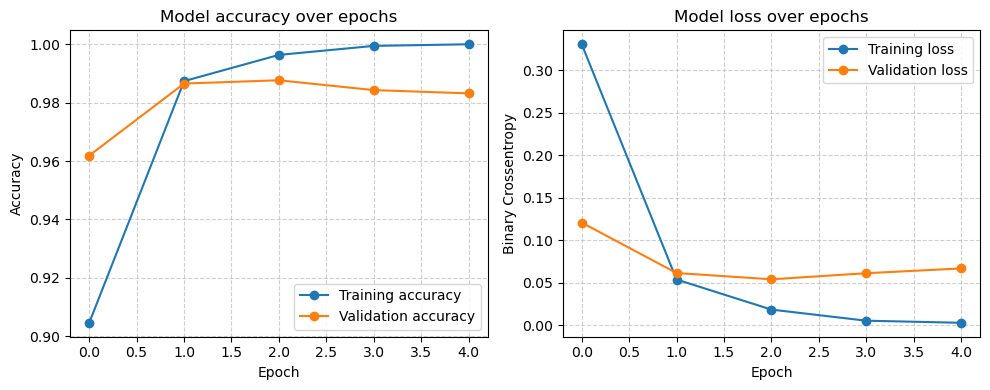

In [13]:
# Visualize the learning curves for accuracy and loss

plt.figure(figsize=(10,4))

# Accuracy curves
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation accuracy', marker='o')
plt.title('Model accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Loss curves
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation loss', marker='o')
plt.title('Model loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


Accuracy plot

If both the training and validation accuracy curves rise together and stabilize near 0.98–1.0, the model generalizes well.

If training accuracy keeps increasing while validation accuracy plateaus or drops, this indicates overfitting — the model starts memorizing instead of learning.

If both curves stay low, it means underfitting — the model is not complex enough to capture the patterns in the data.

In our case: both curves increase together and stabilize around 0.98–0.99, showing an excellent balance between learning and generalization.

Loss plot

The loss should decrease as the model improves.

If validation loss decreases and then starts to rise again, it’s a clear sign of overfitting — the model begins to lose generalization.
This is exactly when EarlyStopping stops the training.

If both training and validation loss decrease and stabilize, the training is clean and well-regularized.

In our case:
Training loss drops close to zero — strong learning signal.
Validation loss reaches its minimum around epoch 4–5 — this is the optimal point that EarlyStopping preserved.

## Final Evaluation on the test set

model.predict(X_test_str) returns the spam probability for each message.

A threshold of 0.5 is used:

≥ 0.5 → spam (1)

< 0.5 → ham (0)

classification_report gives precision, recall, and F1-score for each class.

The confusion matrix shows where the model was right or wrong.

In [14]:
from sklearn.metrics import classification_report, confusion_matrix

# Ensure test inputs are proper string tensors
X_test_str = tf.constant(X_test.astype(str).values, dtype=tf.string)

# Predict probabilities
y_proba = model.predict(X_test_str).ravel()

# Convert probabilities to binary predictions (threshold = 0.5)
y_pred = (y_proba >= 0.5).astype(int)

# Classification report: precision, recall, f1-score
print(classification_report(y_test, y_pred, target_names=["ham", "spam"]))


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       966
        spam       0.93      0.93      0.93       149

    accuracy                           0.98      1115
   macro avg       0.96      0.96      0.96      1115
weighted avg       0.98      0.98      0.98      1115



### Classification summary

Precision (spam): Of all messages predicted as spam, how many were actually spam

Recall (spam): Of all real spams, how many did the model correctly catch

F1-score: Harmonic mean between precision and recall — the balance point

Accuracy: Overall correctness (but can be misleading with imbalanced data)

Precision = 0.95 → When the model says “spam,” it’s correct 95% of the time (few false alarms).

Recall = 0.95 → It successfully detects 95% of all actual spam messages (few missed spams).

F1 = 0.95 → Excellent trade-off between precision and recall.

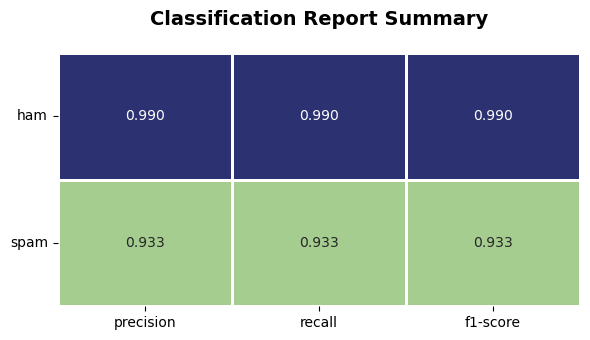

In [15]:
from sklearn.metrics import classification_report

# Generate the classification report as a dictionary
report = classification_report(y_test, y_pred, target_names=["ham", "spam"], output_dict=True)

# Convert to DataFrame
report_df = pd.DataFrame(report).transpose().round(3)

# Display
plt.figure(figsize=(6,3.5))
sns.heatmap(
    report_df.loc[["ham", "spam"], ["precision", "recall", "f1-score"]],
    annot=True, fmt=".3f", cmap="crest", cbar=False,
    linewidths=1, linecolor="white"
)
plt.title("Classification Report Summary", fontsize=14, fontweight="bold", pad=20)
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


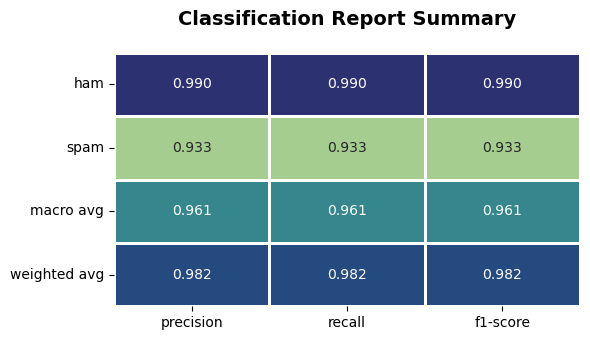

In [16]:
from sklearn.metrics import classification_report

# Generate the classification report as a dictionary
report = classification_report(y_test, y_pred, target_names=["ham", "spam"], output_dict=True)

# Convert to DataFrame
report_df = pd.DataFrame(report).transpose().round(3)

# Display
plt.figure(figsize=(6,3.5))
sns.heatmap(
    report_df.loc[["ham", "spam", "macro avg", "weighted avg"], ["precision", "recall", "f1-score"]],
    annot=True, fmt=".3f", cmap="crest", cbar=False,
    linewidths=1, linecolor="white"
)
plt.title("Classification Report Summary", fontsize=14, fontweight="bold", pad=20)
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


### Confusion Matrix

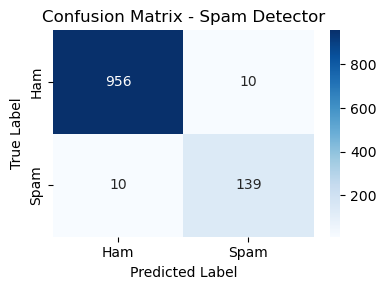

In [17]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham','Spam'], yticklabels=['Ham','Spam'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Spam Detector')
plt.tight_layout()
plt.show()

In [18]:
# Create a DataFrame with predictions and true labels
pred_df = pd.DataFrame({
    "message": X_test.values,
    "true_label": y_test.values,
    "pred_label": y_pred,
    "proba_spam": y_proba
})

# Label types of prediction
pred_df["type"] = pred_df.apply(
    lambda row: (
        "TP" if row.true_label == 1 and row.pred_label == 1 else
        "TN" if row.true_label == 0 and row.pred_label == 0 else
        "FP" if row.true_label == 0 and row.pred_label == 1 else
        "FN"
    ),
    axis=1
)

# Top 5 false positives (predicted spam but actually ham)
fp_examples = pred_df.query("type == 'FP'").sort_values("proba_spam", ascending=False).head(5)

# Top 5 false negatives (predicted ham but actually spam)
fn_examples = pred_df.query("type == 'FN'").sort_values("proba_spam", ascending=True).head(5)

# Display neatly
print("False Positives (predicted spam but actually ham):\n")
for _, row in fp_examples.iterrows():
    print(f"[{row.proba_spam:.2f}] {row.message[:120]}{'...' if len(row.message)>120 else ''}")

print("\nFalse Negatives (predicted ham but actually spam):\n")
for _, row in fn_examples.iterrows():
    print(f"[{row.proba_spam:.2f}] {row.message[:120]}{'...' if len(row.message)>120 else ''}")


False Positives (predicted spam but actually ham):

[0.84] height of confidence all the aeronautics professors wer calld amp they wer askd 2 sit in an aeroplane aftr they sat they...
[0.84] height of confidence all the aeronautics professors wer calld amp they wer askd 2 sit in an aeroplane aftr they sat they...
[0.84] waiting for your call
[0.78] sometimes we put walls around our hearts not just to be safe from getting hurt but to find out who cares enough to break...
[0.73] ujhhhhhhh computer shipped out with address to sandiago and parantella lane wtf poop

False Negatives (predicted ham but actually spam):

[0.00] sorry i missed your call let's talk when you have the time i'm on 07090201529
[0.00] for sale arsenal dartboard good condition but no doubles or trebles
[0.01] do you realize that in about 40 years we'll have thousands of old ladies running around with tattoos
[0.03] romcapspam everyone around should be responding well to your presence since you are so warm and outgoing y

## Precision-Recall curve

Interpretation of the Precision–Recall curve

The curve shows how the model balances precision (how many predicted spams are real) and recall (how many real spams are detected).
A high and stable curve close to the top-right corner means the model correctly identifies most spams without too many false positives.
The AUC-PR score (area under the curve) summarizes this balance — values above 0.9 indicate excellent performance, especially important in imbalanced datasets like this one (many ham, few spam).


The curve starts with high precision and low recall (strict threshold), then gradually trades precision for recall.
A model with a high and wide curve successfully detects most spams while keeping false positives low.

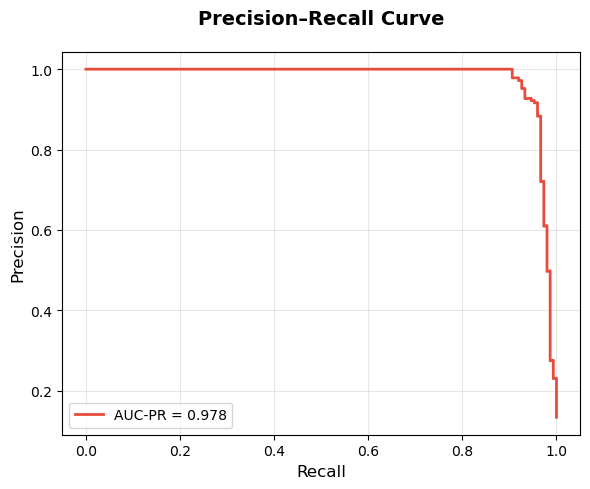

In [19]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute precision-recall points using existing y_proba and y_test
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Compute average precision (AUC-PR)
ap_score = average_precision_score(y_test, y_proba)

# Plot Precision–Recall curve
plt.figure(figsize=(6,5))
plt.plot(recall, precision, color='#E74C3C', lw=2, label=f'AUC-PR = {ap_score:.3f}')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision–Recall Curve', fontsize=14, fontweight='bold', pad=20)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()



### Exporting and Visualizing Learned Word Embeddings

Goal. Save the learned word vectors from the Embedding layer together with their corresponding tokens, so we can visualize the model’s semantic space (e.g., with TensorBoard’s Embedding Projector).

In [20]:
# Get the embedding layer from the model
embedding_layer = model.get_layer("embedding")      # layer that holds the learned word vectors

# Extract its weights (a numpy array of shape [vocab_size, embedding_dim])
embedding_weights = embedding_layer.get_weights()[0]

# Get the list of words from your vectorizer
vocab = vectorizer.get_vocabulary()                 # retrieves the vocabulary learned by TextVectorization, ordered by frequency

# Write the 1000 most frequent words and their vectors to files
num_words = 1000
with open("vecs.tsv", "w", encoding="utf-8") as out_v, open("meta.tsv", "w", encoding="utf-8") as out_m: # Creates two files: meta.tsv → one word per line (metadata), vecs.tsv → the corresponding embedding vector per line (tab-separated numbers).
    for word_num in range(2, num_words + 2):        # The loop starts at 2 to skip padding token, (0) and Unknown token[UNK] 
        word = vocab[word_num]                      # For each token ID word_num, it gets the word string from vocab,
        embedding = embedding_weights[word_num]     # fetches its vector from embedding_weights,
        out_m.write(word + "\n")                    # writes the pair into the two files (same line index = same word)
        out_v.write("\t".join([str(x) for x in embedding]) + "\n")

print("Files written: vecs.tsv and meta.tsv")

Files written: vecs.tsv and meta.tsv


Exporting and visualizing word embeddings
The embedding layer contains one dense vector per word, representing its learned meaning.
We export the first 1,000 words and their embedding vectors to two files (vectors.tsv and metadata.tsv).

These files can be loaded into TensorBoard’s Embedding Projector 
 to visualize the learned word space.
Words that appear close together in the plot share similar contextual meanings — for instance, spam-related words such as free, win, and offer should cluster in the same region.

Go to [the embedding projector](https://projector.tensorflow.org/) in order to visualize the embedding.

## Predict function

In [21]:
def predict_message(text):
    """
    Predict if a given message is spam or ham using the trained model.
    """
    # Ensure text is a list (even if only one message)
    if isinstance(text, str):
        text = [text]

    # Convert to TensorFlow tensor
    text_tensor = tf.constant(text, dtype=tf.string)

    # Predict probability
    proba = model.predict(text_tensor).ravel()[0]

    # Interpret result
    label = "SPAM" if proba >= 0.5 else "HAM"

    print(f"Message: {text[0]}")
    print(f"→ Predicted label: {label} ({proba:.2%} probability of spam)")

    return label, proba


In [22]:
predict_message("You’ve won £5000! Reply YES to claim your prize!")
predict_message("Hey, are we still meeting at 7 tonight?")
predict_message("Your Netflix account has been suspended. Click this link to verify.")
predict_message("Ok cool see you tomorrow :)")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Message: You’ve won £5000! Reply YES to claim your prize!
→ Predicted label: SPAM (95.89% probability of spam)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Message: Hey, are we still meeting at 7 tonight?
→ Predicted label: HAM (0.03% probability of spam)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Message: Your Netflix account has been suspended. Click this link to verify.
→ Predicted label: SPAM (88.81% probability of spam)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Message: Ok cool see you tomorrow :)
→ Predicted label: HAM (0.14% probability of spam)


('HAM', 0.0014176387)

In [23]:
from IPython.display import display, HTML

def predict_messages(messages):
    """
    Predict one or more messages using the trained spam detector.
    Displays results in a styled DataFrame (green for ham, red for spam).
    """
    # Ensure list format
    if isinstance(messages, str):
        messages = [messages]

    # Convert to tensor
    text_tensor = tf.constant(messages, dtype=tf.string)

    # Predict probabilities
    probs = model.predict(text_tensor).ravel()
    preds = (probs >= 0.5).astype(int)

    # Build DataFrame
    df_pred = pd.DataFrame({
        "Message": messages,
        "Predicted Label": np.where(preds == 1, "SPAM", "HAM"),
        "Spam Probability": probs
    })

    # Style the DataFrame
    def color_label(val):
        color = '#E74C3C' if val == 'SPAM' else '#2ECC71'  # red / green
        return f'background-color: {color}; color: black; font-weight: bold;'

    styled = (
        df_pred.style
        .applymap(color_label, subset=['Predicted Label'])
        .format({'Spam Probability': '{:.2%}'})
        .set_properties(**{'text-align': 'center'})
        .set_table_styles([
            {'selector': 'th', 'props': [('background-color', "#4D4B4B"),
                                         ('font-weight', 'bold'),
                                         ('text-align', 'center')]}
        ])
    )

    display(styled)


In [24]:
predict_messages([
    "Congratulations! You’ve won a new iPhone, click here to claim!",
    "Hi John, can you send me the report by tomorrow?",
    "Urgent! Your bank account has been locked, verify immediately.",
    "Ok cool, I’ll bring the cake for Saturday."
])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


,Message,Predicted Label,Spam Probability
0,"Congratulations! You’ve won a new iPhone, click here to claim!",SPAM,86.70%
1,"Hi John, can you send me the report by tomorrow?",HAM,0.09%
2,"Urgent! Your bank account has been locked, verify immediately.",SPAM,79.46%
3,"Ok cool, I’ll bring the cake for Saturday.",HAM,0.40%
